## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## 1.  compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

def get_calibration_mtx():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('../camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            cv2.imshow('img',img)
            cv2.waitKey(500)

    cv2.destroyAllWindows()
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx, dist

### Computer camera calibration matrix

In [2]:
%matplotlib qt
mtx, dist = get_calibration_mtx()

## 2. use the calibration for new image testing  

In [3]:
%matplotlib inline
import numpy as np

def testimg_calibration(mtx, dist):
    images = glob.glob('../camera_cal/calibration*.jpg')
    testidx = np.random.randint(0, len(images))
    print('test on image file ', images[testidx])
    img = cv2.imread(images[testidx])

    dst = cv2.undistort(img, mtx, dist, None, mtx)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

test on image file  ../camera_cal\calibration14.jpg


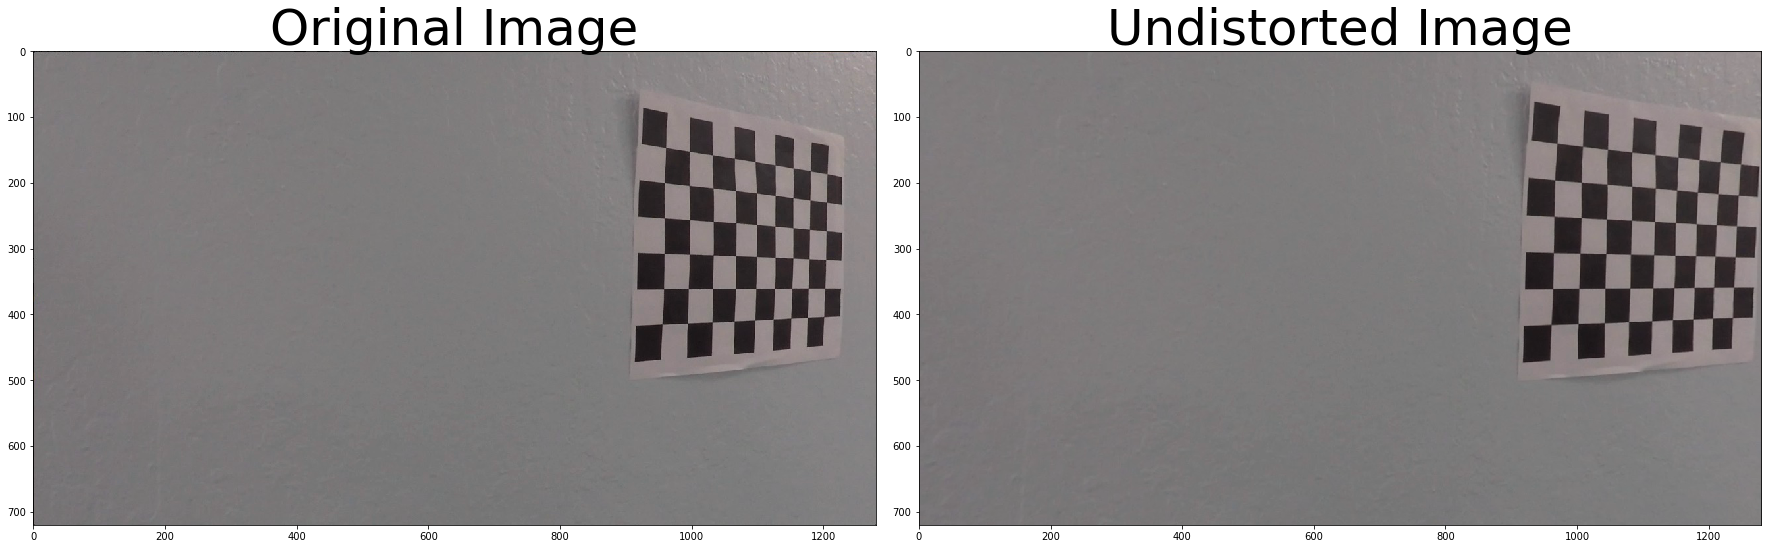

In [4]:
testimg_calibration(mtx, dist)


## 3 Apply a perspective transform to rectify binary image ("birds-eye view").
find a proper image to do the perspective transform


In [5]:
import os
%matplotlib inline
def get_perspective_transform_mtx():
    pers_img = os.path.join('..', 'test_images', 'straight_lines1.jpg')
    print(pers_img)
    img = cv2.imread(pers_img)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    src = np.float32([[603, 444], [675, 444], [1050, 688], [253, 688]])
    dst = np.float32([[250, 0], [1050, 0], [1050, 700], [250, 700]])
    '''
          1   2
           ---
          /   \
         /     \
        /       \
        ---------
       4         3 
    '''
    plt.plot(*src[0], '.', color = 'r')
    plt.plot(*src[1], '.', color = 'r')
    plt.plot(*src[2], '.', color = 'r')
    plt.plot(*src[3], '.', color = 'r')
    plt.plot(*dst[0], 'x', color = 'y')
    plt.plot(*dst[1], 'x', color = 'y')
    plt.plot(*dst[2], 'x', color = 'y')
    plt.plot(*dst[3], 'x', color = 'y')

    # computer the perspective transformation matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv


..\test_images\straight_lines1.jpg


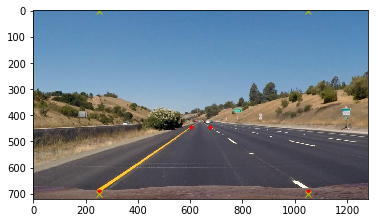

In [6]:
M, Minv = get_perspective_transform_mtx()

In [7]:
def testimg_perspective_transform(m):
    # do transformation on the test image
    # check the final warped image after perspective transformation
    imgname = os.path.join('..', 'test_images', 'straight_lines1.jpg')
    img = cv2.imread(imgname)    
    img_size = img.shape[1], img.shape[0]
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))

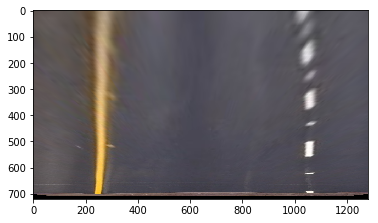

In [8]:
testimg_perspective_transform(M)   

## 4. Use color transforms, gradients, etc., to create a thresholded binary image.
define a function called bin img selection

In [9]:
from cv2 import Sobel

def build_binary_img(img, rawtype = 'bgr', orient = 'x', sobeltype = 's', s_thresh = (170, 255), sobel_thresh = (20, 100)):
    if rawtype == 'rgb': # cv2.imread()
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif rawtype == 'bgr': # matplotlib.image.imread()
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    else:  # gray
        assert 0

    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    channel = gray
    sobelx = Sobel(channel, cv2.CV_64F, 1, 0)
    sobelx = np.absolute(sobelx)
    sobelx = np.uint8(255*sobelx/np.max(sobelx))
    
    sobely = Sobel(channel, cv2.CV_64F, 0, 1)
    sobely = np.absolute(sobely)
    sobely = np.uint8(255*sobely/np.max(sobely))

    # sobel_thresh = (20, 100)
    sobel_bin = np.zeros_like(sobelx)
    if orient == 'x':
        sobel_bin[(sobelx >= sobel_thresh[0]) & (sobelx <= sobel_thresh[1])] = 1
    else:
        sobel_bin[(sobely >= sobel_thresh[0]) & (sobely <= sobel_thresh[1])] = 1
        
    channel = S
    color_bin = np.zeros_like(channel)
    if orient == 'x':
        color_bin[(channel >= s_thresh[0]) & (channel <= s_thresh[1])] = 1
    else:
        color_bin[(channel >= s_thresh[0]) & (channel <= s_thresh[1])] = 1

    combined_bin = np.zeros_like(gray)
    combined_bin[(color_bin == 1) | (sobel_bin == 1)] = 1

#     sobel_bin = np.dstack(sobel_bin*3) *255
#     color_bin = np.dstack(color_bin*3) *255
#     combined_bin = np.dstack(combined_bin*3) *255
    
    return sobel_bin*255, color_bin*255, combined_bin*255

In [10]:
def testimg_build_binary():
    # test the function build_binary_image()
    images = glob.glob('../test_images/*.jpg')
    testidx = np.random.randint(0, len(images))
    print('testing the binary img build function on test image ', images[testidx])
    img = cv2.imread(images[testidx])

    img0 = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

    img1, img2, img3 = build_binary_img(img0, rawtype = 'rgb' )

    f, ax = plt.subplots(2, 3, figsize=(48, 18))
    f.tight_layout()
    ax[0][0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[0][0].set_title('Original Image', fontsize=32)
    
    ax[0][1].imshow(cv2.cvtColor(img0, cv2.COLOR_BGR2RGB))
    ax[0][1].set_title('perspective transformed img', fontsize=32)
    
    ax[0][2].imshow(img1, cmap = 'gray')
    ax[0][2].set_title('gray sobel x Image', fontsize=32)

    ax[1][0].imshow(img2, cmap = 'gray')
    ax[1][0].set_title('s color channel Image', fontsize=32)

    ax[1][1].imshow(img3, cmap = 'gray')
    ax[1][1].set_title('combin bin Image', fontsize=32)

    plt.subplots_adjust(left=0.1, right=1, top=0.9, bottom=0, wspace=None, hspace=0.4)
    
    # img, img0 are color imgs
    # img1, img2, img3 are gray imgs
    return img, img0, img1, img2, img3

testing the binary img build function on test image  ../test_images\straight_lines1.jpg


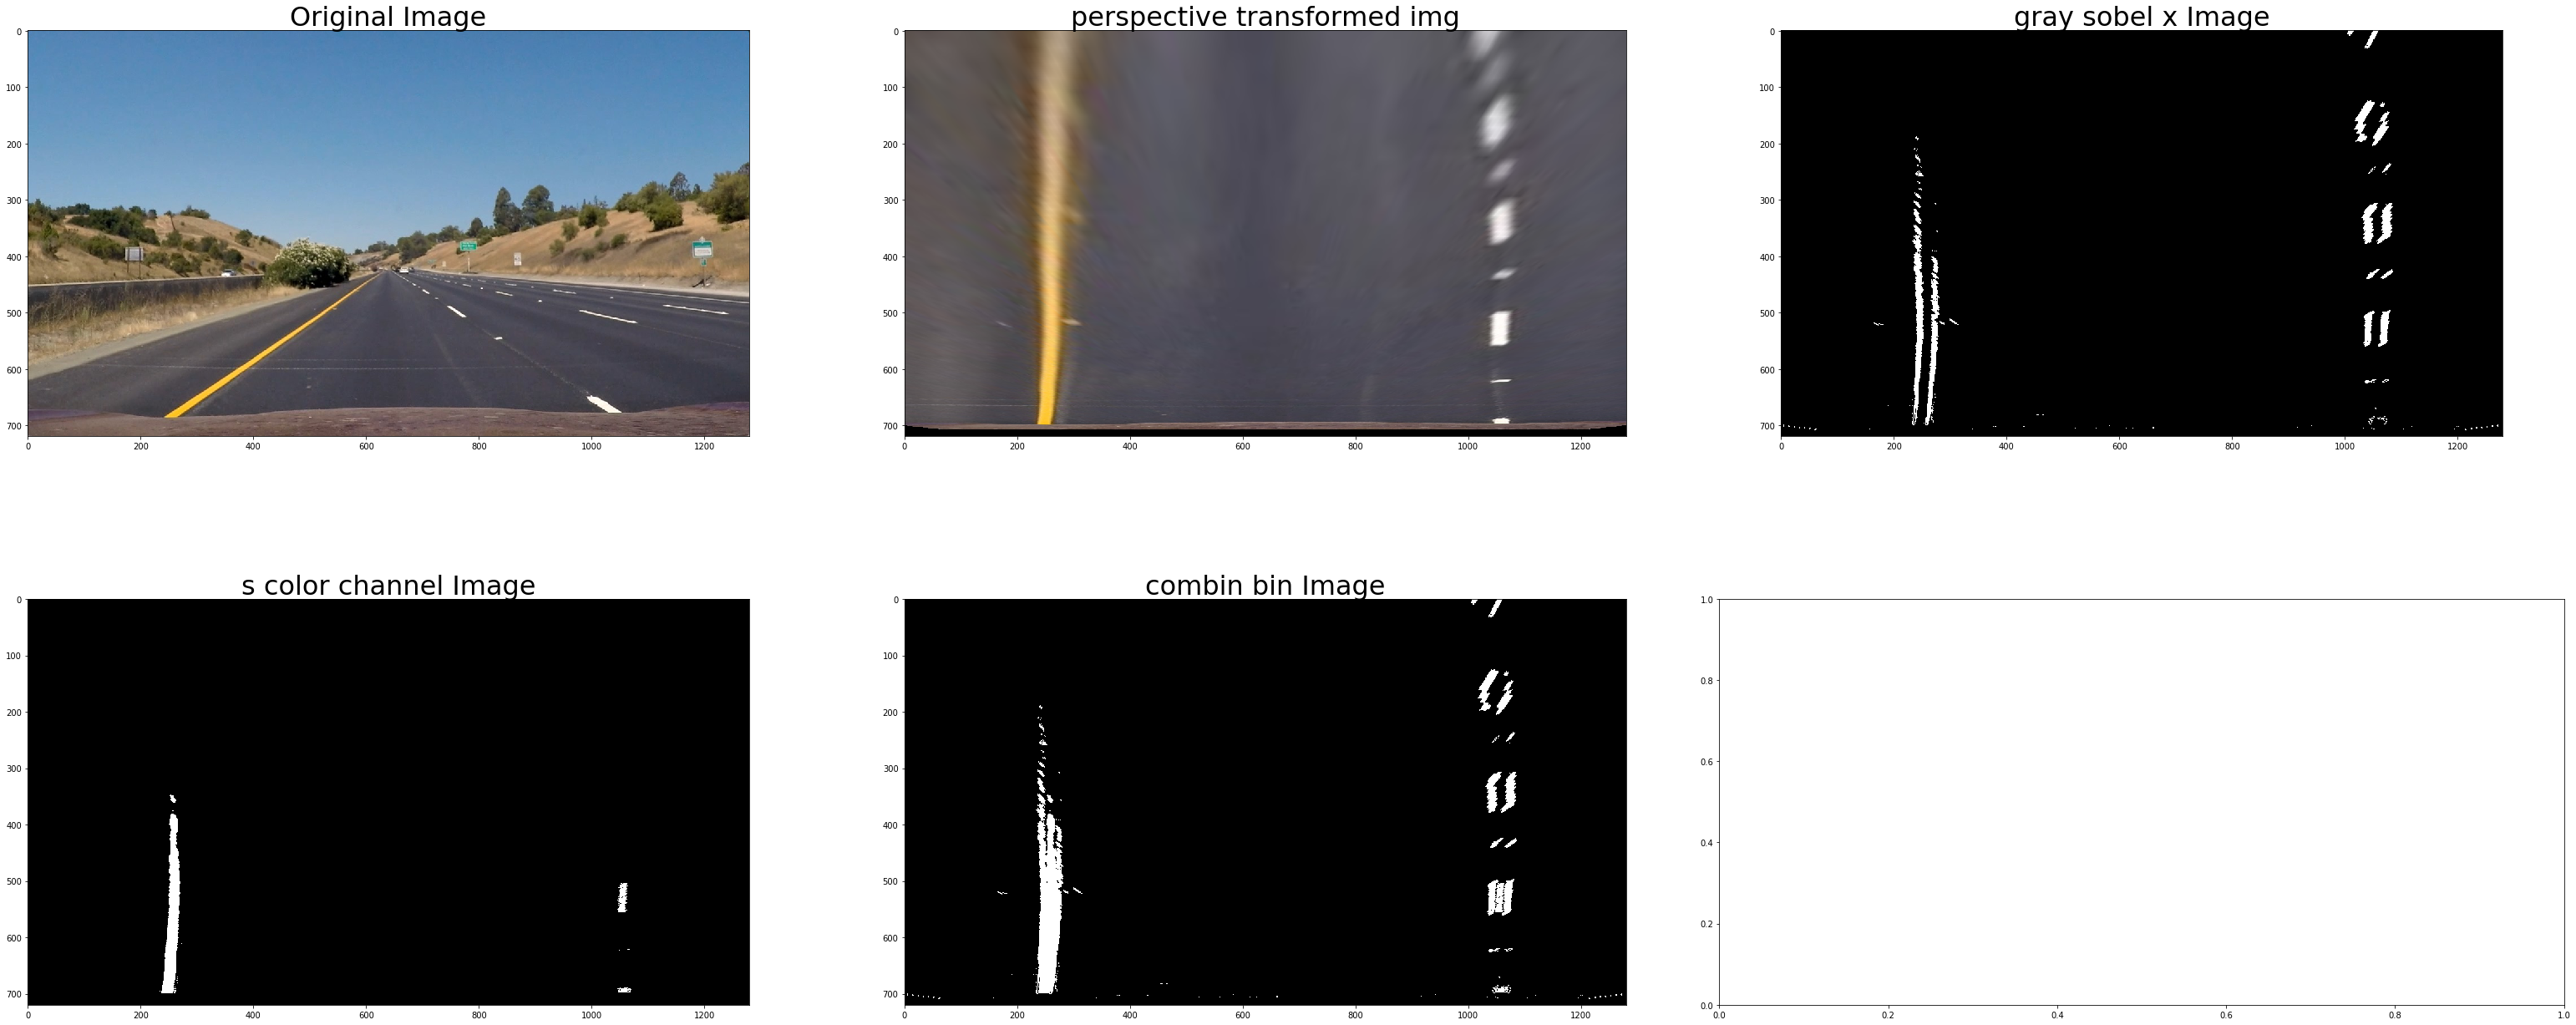

In [11]:
rawimg, img0, img1, img2, img3 = testimg_build_binary()

### 5. Detect lane pixels and fit to find the lane boundary.

In [28]:

def get_histogram(img):
    
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # as in the persepctive transformation, we have already changed the bottom half to the whole image,
    # then no need to only use the bottom half, just use the whole half
    histogram = np.sum(img[:,:], axis=0)
    out_img = np.dstack((img, img, img))
#     plt.imshow(out_img)
#     plt.show()
#     plt.plot(histogram)
#     plt.show()    
    return histogram

In [29]:
# img is the raw color img,
# img0 is the perspectived img
# img1 is the sobel x binary img
# img2 is the color threshold img
# img3 is the combination of img2 and img3

histogram = get_histogram(img3)

Sliding Window

In [30]:
# we use a class to collect all the variables together in a scope

# use it as global as it not changed [y_pixdels, x_pixels]
imgsize = img3.shape


class LaneLineHandler(object):
    def __init__(self):
        self.nwindows = 9
        self.window_height = np.int(imgsize[0]/self.nwindows)
        self.margin = 100
        self.minpix = 50
        self.left_lane_inds = []
        self.right_lane_inds = []
        self.ym_per_pix = 30/720 # meters per pixel in y dimension
        self.xm_per_pix = 3.7/700
        
        
    def readin(self, img):
        # readin the raw color image taken from the camera
        
        self.raw = img
        img0 = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
        img1, img2, img3 = build_binary_img(img0, rawtype = 'rgb' )
        
        self.histogram = get_histogram(img3)
        # print(self.histogram.shape)
        self.midpoint = np.int(self.histogram.shape[0]/2)
        self.leftx_base = np.argmax(self.histogram[:self.midpoint])
        self.rightx_base = np.argmax(self.histogram[self.midpoint:]) + self.midpoint
        # print('left base is: ', self.leftx_base, ' right base is: ', self.rightx_base)

        # out_color is color image
        self.out_color = np.dstack((img3, img3, img3))
        
        self.nonzero = self.out_color.nonzero()
        self.nonzerox = np.array(self.nonzero[1])
        self.nonzeroy = np.array(self.nonzero[0])
        # print('non zero points in x: ', len(self.nonzerox))
        self.leftx_current = self.leftx_base
        self.rightx_current = self.rightx_base
    
    def showOutImg(self):
        plt.imshow(self.out_color)
        
    def slidingWindow(self, plotRectangle = True):
        # Step through the windows one by one
        for window in range(self.nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = self.out_color.shape[0] - (window+1)*self.window_height
            win_y_high = self.out_color.shape[0] - window*self.window_height
            win_xleft_low = self.leftx_current - self.margin
            win_xleft_high = self.leftx_current + self.margin
            win_xright_low = self.rightx_current - self.margin
            win_xright_high = self.rightx_current + self.margin
            # Draw the windows on the visualization image
            if plotRectangle:
                cv2.rectangle(self.out_color,
                              (win_xleft_low, win_y_low), (win_xleft_high,win_y_high),
                              (0,255,0), 3) 
                # print('build a rectangle : (', win_xleft_low, win_y_low, '), (', win_xleft_high, win_y_high,')')
                cv2.rectangle(self.out_color,
                              (win_xright_low,win_y_low),(win_xright_high,win_y_high), 
                              (0,255,0), 3) 
            # print('build a rectangle : (', win_xright_low, win_y_low, '), (', win_xright_high, win_y_high,')')
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((self.nonzeroy >= win_y_low) & (self.nonzeroy < win_y_high) & 
                              (self.nonzerox >= win_xleft_low) &  (self.nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((self.nonzeroy >= win_y_low) & (self.nonzeroy < win_y_high) & 
                               (self.nonzerox >= win_xright_low) &  (self.nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            # print(good_left_inds.shape, good_right_inds.shape)
            self.left_lane_inds.append(good_left_inds)
            self.right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            # print('len good_left_inds is: ', len(good_left_inds))
            if len(good_left_inds) > self.minpix:
                self.leftx_current = np.int(np.mean(self.nonzerox[good_left_inds]))
            # print('len good_right_inds is: ', len(good_right_inds))
            if len(good_right_inds) > self.minpix:
                self.rightx_current = np.int(np.mean(self.nonzerox[good_right_inds]))
            
            # mark left lane pixels as red, right lane [ixels as blue]
    def markLanepixelColor(self):
        self.left_lane_inds = np.concatenate(self.left_lane_inds)
        self.right_lane_inds = np.concatenate(self.right_lane_inds)

        self.out_color[self.nonzeroy[self.left_lane_inds], self.nonzerox[self.left_lane_inds]] = [255, 0, 0]
        self.out_color[self.nonzeroy[self.right_lane_inds],self.nonzerox[self.right_lane_inds]] = [0, 0, 255]
    
    def fitting(self):
        # Extract left and right line pixel positions
        leftx = self.nonzerox[self.left_lane_inds]
        lefty = self.nonzeroy[self.left_lane_inds] 
        rightx = self.nonzerox[self.right_lane_inds]
        righty = self.nonzeroy[self.right_lane_inds] 

        # Fit a second order polynomial to each
        self.left_fit = np.polyfit(lefty, leftx, 2)
        self.right_fit = np.polyfit(righty, rightx, 2)
        
        self.left_fit_meter = np.polyfit(lefty * self.ym_per_pix, leftx * self.xm_per_pix, 2)
        self.right_fit_meter = np.polyfit(righty * self.ym_per_pix, rightx * self.xm_per_pix, 2)
        
        ploty = np.linspace(0, imgsize[0]-1, imgsize[0] )
        self.left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
        self.right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]
        
    def showFitting(self):
        # Generate x and y values for plotting
        ploty = np.linspace(0, imgsize[0]-1, imgsize[0] )
        self.left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
        self.right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]

        plt.imshow(self.out_color)
        plt.plot(self.left_fitx, ploty, color='yellow')
        plt.plot(self.right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
        
    def nextFitting(self, newimg):
        # quick find the fitting of the new image based on the new image
        nonzero = newimg.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # margin = 100
        left_lane_inds = (
            (nonzerox > (self.left_fit[0]*(nonzeroy**2) + self.left_fit[1]*nonzeroy + self.left_fit[2] - self.margin)) &
            (nonzerox < (self.left_fit[0]*(nonzeroy**2) + self.left_fit[1]*nonzeroy + self.left_fit[2] + self.margin))) 

        right_lane_inds = (
            (nonzerox > (self.right_fit[0]*(nonzeroy**2) + self.right_fit[1]*nonzeroy + self.right_fit[2] - self.margin)) & 
            (nonzerox < (self.right_fit[0]*(nonzeroy**2) + self.right_fit[1]*nonzeroy + self.right_fit[2] + self.margin)))  

        # Again, extract left and right line pixel positions
        self.leftx = nonzerox[left_lane_inds]
        self.lefty = nonzeroy[left_lane_inds] 
        self.rightx = nonzerox[right_lane_inds]
        self.righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        
        self.left_fit = np.polyfit(self.lefty, self.leftx, 2)
        self.right_fit = np.polyfit(self.righty, self.rightx, 2)
    
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        self.left_fit_meter = np.polyfit(self.lefty * self.ym_per_pix, self.leftx * self.xm_per_pix, 2)
        self.right_fit_meter = np.polyfit(self.righty * self.ym_perpix, slef.rightx * self.xm_per_pix, 2)
        # Generate x and y values for plotting
        # ploty = np.linspace(0, img3.shape[0]-1, img3.shape[0] )
        self.left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
        self.right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]
    
    # after a new raw file read in, do the fitting based on the new image
    def showFitting2(self):
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((self.raw , self.raw, self.raw))
        
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[self.nonzeroy[self.left_lane_inds], self.nonzerox[self.left_lane_inds]] = [255, 0, 0]
        out_img[self.nonzeroy[self.right_lane_inds], self.nonzerox[self.right_lane_inds]] = [0, 0, 255]

        ploty = np.linspace(0, imgsize[0]-1, imgsize[0] )
        left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
        right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]
        
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - self.margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + self.margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - self.margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + self.margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    
    def calcCurvature(self):
        ploty = np.linspace(0, imgsize[0]-1, imgsize[0] )

        y_eval = np.max(ploty)
        # calc the curvature at the bottom,e.g., close to the car
        # x = a*y^2 + b*y + c 
        # R_curve = [1 + (2a+b)^2]^(3/2)/ |2a|

        self.left_curverad = ((1 + (2*self.left_fit[0]*y_eval + self.left_fit[1])**2)**1.5) / np.absolute(2*self.left_fit[0])
        self.right_curverad = ((1 + (2*self.right_fit[0]*y_eval + self.right_fit[1])**2)**1.5) / np.absolute(2*self.right_fit[0])

        y_eval = y_eval * self.ym_per_pix
        self.left_curverad_meter =((1 + (2*self.left_fit_meter[0]* y_eval + self.left_fit_meter[1])**2)**1.5) / np.absolute(2*self.left_fit_meter[0])
        self.right_curverad_meter = ((1 + (2*self.right_fit_meter[0] * y_eval + self.right_fit_meter[1])**2)**1.5) / np.absolute(2*self.right_fit_meter[0])
        print('left curvature is: ', self.left_curverad, ' pixels, e.g, ', self.left_curverad_meter, ' meters')
        print('right curvature is: ', self.right_curverad, ' pixels, e.g, ', self.right_curverad_meter, ' meters')
    
    def drawBack(self):
        # Create an image to draw the lines on
        color_warp = np.zeros_like(self.raw).astype(np.uint8)
        # color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        ploty = np.linspace(0, imgsize[0]-1, imgsize[0] )
            
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([self.left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([self.right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (imgsize[1], imgsize[0])) 
        
        # Combine the result with the original image
        result = cv2.addWeighted(self.raw, 1, newwarp, 0.3, 0)
        plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        return result
    
    def run(self, img):
        self.readin(img)
        self.slidingWindow(plotRectangle = False)
        self.markLanepixelColor()
        self.fitting()
        self.calcCurvature()
        result = self.drawBack()
        return result

left curvature is:  1809.63442223  pixels, e.g,  583.349489529  meters
right curvature is:  5207.46149138  pixels, e.g,  1704.96358129  meters


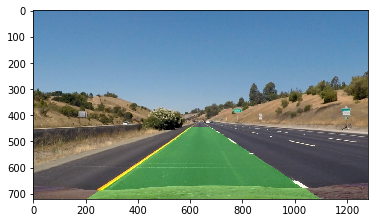

In [31]:
handler = LaneLineHandler()
result = handler.run(rawimg)

In [32]:
handler = LaneLineHandler()
handler.readin(rawimg)

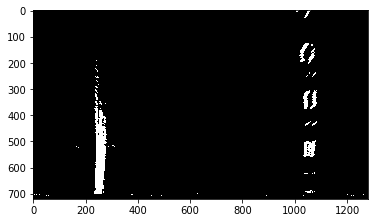

In [33]:
handler.showOutImg()

In [34]:
handler.slidingWindow()

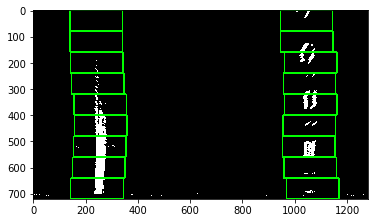

In [35]:
handler.showOutImg()

In [36]:
handler.markLanepixelColor()

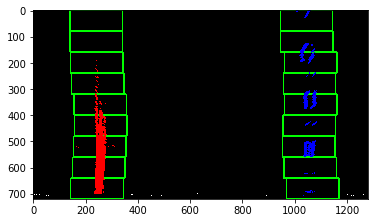

In [37]:
handler.showOutImg()

In [38]:
handler.fitting()

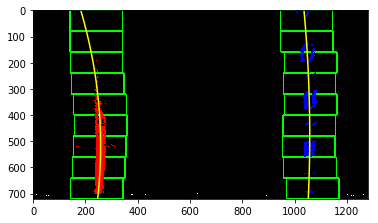

In [39]:
handler.showFitting()

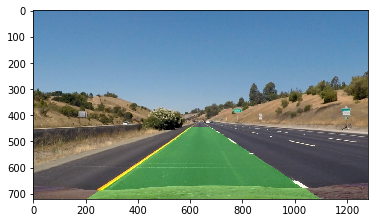

In [40]:
result = handler.drawBack()

### 7. Warp the detected lane boundaries back onto the original image.

In [41]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

### 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### 9. final pipe line function

In [42]:
# function for video handling
def process_image(img):
    handler = LaneLineHandler()
    result = handler.run(img)
    return result

../output_images\test1.jpg
left curvature is:  492.074513547  pixels, e.g,  152.684656868  meters
right curvature is:  549.038073786  pixels, e.g,  172.16909536  meters
../output_images\test2.jpg
left curvature is:  663.696199185  pixels, e.g,  217.731371199  meters
right curvature is:  730.02274125  pixels, e.g,  114.886374031  meters
../output_images\test3.jpg
left curvature is:  1233.61413088  pixels, e.g,  370.2503683  meters
right curvature is:  780.04157085  pixels, e.g,  250.41977607  meters
../output_images\test4.jpg
left curvature is:  811.71753774  pixels, e.g,  259.969449166  meters
right curvature is:  434.053312168  pixels, e.g,  96.0653848763  meters
../output_images\test5.jpg
left curvature is:  483.218747043  pixels, e.g,  143.685147581  meters
right curvature is:  478.274808942  pixels, e.g,  142.919714086  meters
../output_images\test6.jpg
left curvature is:  1156.73157604  pixels, e.g,  340.428038183  meters
right curvature is:  561.34014453  pixels, e.g,  183.990679

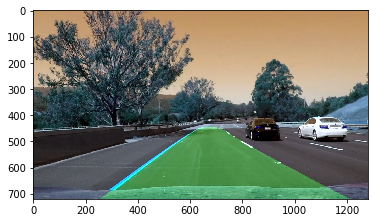

In [43]:
imgnames = glob.glob('../test_images/test*.jpg')
for imgname in imgnames:
#     img = cv2.imread(imgname)
#     result = process_image(img)
    dirname, filename = os.path.split(imgname)
    newimgname = os.path.join('../output_images', filename)
    print(newimgname)
    img = cv2.imread(imgname)
    result = process_image(img)
    plt.imshow(result)
    
    cv2.imwrite(newimgname, result)

                   

In [ ]:
from moviepy.editor import VideoFileClip
video_input = '../project_video.mp4'
video_output = '../project_solution.mp4'
# challenge_output = 'test_videos_output/challenge.mp4'

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip(video_input).subclip(0,5)
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(video_output, audio=False)

left curvature is:  670.294186068  pixels, e.g,  220.151256973  meters
right curvature is:  805.843060784  pixels, e.g,  262.927406647  meters
[MoviePy] >>>> Building video ../project_solution.mp4
[MoviePy] Writing video ../project_solution.mp4


  0%|                                                                                          | 0/126 [00:00<?, ?it/s]

left curvature is:  670.294186068  pixels, e.g,  220.151256973  meters
right curvature is:  805.843060784  pixels, e.g,  262.927406647  meters


  1%|▋                                                                                 | 1/126 [00:00<00:47,  2.66it/s]

left curvature is:  658.881413406  pixels, e.g,  216.408698922  meters
right curvature is:  932.047175762  pixels, e.g,  297.279403518  meters


  2%|█▎                                                                                | 2/126 [00:00<00:41,  2.97it/s]

left curvature is:  663.393007811  pixels, e.g,  217.864776533  meters
right curvature is:  692.989376962  pixels, e.g,  226.218968609  meters


  2%|█▉                                                                                | 3/126 [00:00<00:38,  3.24it/s]

left curvature is:  635.708728019  pixels, e.g,  208.80064373  meters
right curvature is:  759.433019142  pixels, e.g,  243.983795152  meters


  3%|██▌                                                                               | 4/126 [00:01<00:35,  3.45it/s]

left curvature is:  659.36017742  pixels, e.g,  216.362786164  meters
right curvature is:  481.107778576  pixels, e.g,  149.158469261  meters


  4%|███▎                                                                              | 5/126 [00:01<00:33,  3.59it/s]

left curvature is:  684.280779221  pixels, e.g,  224.061276091  meters
right curvature is:  821.975440778  pixels, e.g,  259.924195802  meters


  5%|███▉                                                                              | 6/126 [00:01<00:34,  3.51it/s]

left curvature is:  725.339381345  pixels, e.g,  236.351502319  meters
right curvature is:  785.460860146  pixels, e.g,  250.199875716  meters


  6%|████▌                                                                             | 7/126 [00:01<00:32,  3.64it/s]

left curvature is:  716.821278552  pixels, e.g,  233.269619576  meters
right curvature is:  845.396413774  pixels, e.g,  265.407158583  meters


  6%|█████▏                                                                            | 8/126 [00:02<00:31,  3.78it/s]

left curvature is:  758.382221701  pixels, e.g,  245.289293052  meters
right curvature is:  815.104520316  pixels, e.g,  257.826440211  meters


  7%|█████▊                                                                            | 9/126 [00:02<00:29,  3.92it/s]

left curvature is:  783.258902565  pixels, e.g,  251.910041913  meters
right curvature is:  701.449461534  pixels, e.g,  227.635466267  meters


  8%|██████▍                                                                          | 10/126 [00:02<00:28,  4.05it/s]

left curvature is:  762.522483518  pixels, e.g,  245.702971562  meters
right curvature is:  718.5336253  pixels, e.g,  231.147715639  meters


  9%|███████                                                                          | 11/126 [00:02<00:28,  4.10it/s]

left curvature is:  892.878285316  pixels, e.g,  281.23872582  meters
right curvature is:  1067.55444029  pixels, e.g,  331.41801448  meters


 10%|███████▋                                                                         | 12/126 [00:03<00:27,  4.20it/s]

left curvature is:  858.533708382  pixels, e.g,  271.811713547  meters
right curvature is:  718.651731995  pixels, e.g,  233.62506956  meters


 10%|████████▎                                                                        | 13/126 [00:03<00:26,  4.25it/s]

left curvature is:  814.135664531  pixels, e.g,  259.573939404  meters
right curvature is:  745.217874063  pixels, e.g,  241.292488536  meters


 11%|█████████                                                                        | 14/126 [00:03<00:25,  4.34it/s]

left curvature is:  734.375443986  pixels, e.g,  237.057396597  meters
right curvature is:  1017.72908129  pixels, e.g,  305.245957078  meters


 12%|█████████▋                                                                       | 15/126 [00:03<00:24,  4.44it/s]

left curvature is:  690.137558639  pixels, e.g,  224.187297398  meters
right curvature is:  923.93503233  pixels, e.g,  275.799872561  meters


 13%|██████████▎                                                                      | 16/126 [00:03<00:24,  4.45it/s]

left curvature is:  663.079832686  pixels, e.g,  216.057057885  meters
right curvature is:  899.834435176  pixels, e.g,  271.479872428  meters


 13%|██████████▉                                                                      | 17/126 [00:04<00:24,  4.43it/s]

left curvature is:  653.755911267  pixels, e.g,  213.19314657  meters
right curvature is:  987.080728495  pixels, e.g,  291.454822778  meters


 14%|███████████▌                                                                     | 18/126 [00:04<00:24,  4.44it/s]

left curvature is:  687.178513576  pixels, e.g,  223.048493766  meters
right curvature is:  964.884512396  pixels, e.g,  289.299556273  meters


 15%|████████████▏                                                                    | 19/126 [00:04<00:24,  4.45it/s]

left curvature is:  735.22346435  pixels, e.g,  236.894367463  meters
right curvature is:  848.7373355  pixels, e.g,  263.64190237  meters


 16%|████████████▊                                                                    | 20/126 [00:04<00:23,  4.55it/s]

left curvature is:  795.033837713  pixels, e.g,  253.841636984  meters
right curvature is:  635.548359269  pixels, e.g,  207.117113406  meters


 17%|█████████████▌                                                                   | 21/126 [00:05<00:23,  4.54it/s]

left curvature is:  799.826037504  pixels, e.g,  255.002426792  meters
right curvature is:  645.381617366  pixels, e.g,  211.263097667  meters


 17%|██████████████▏                                                                  | 22/126 [00:05<00:22,  4.62it/s]

left curvature is:  798.583665451  pixels, e.g,  255.373203672  meters
right curvature is:  684.859978212  pixels, e.g,  224.196937246  meters


 18%|██████████████▊                                                                  | 23/126 [00:05<00:22,  4.62it/s]

left curvature is:  712.160034948  pixels, e.g,  231.121195065  meters
right curvature is:  770.263823824  pixels, e.g,  248.510002739  meters


 19%|███████████████▍                                                                 | 24/126 [00:05<00:22,  4.57it/s]

left curvature is:  669.492864447  pixels, e.g,  218.589191228  meters
right curvature is:  696.4169718  pixels, e.g,  226.035320416  meters


 20%|████████████████                                                                 | 25/126 [00:05<00:21,  4.64it/s]

left curvature is:  670.138645522  pixels, e.g,  219.076021223  meters
right curvature is:  689.453972195  pixels, e.g,  225.244404837  meters


 21%|████████████████▋                                                                | 26/126 [00:06<00:21,  4.61it/s]

left curvature is:  648.508376209  pixels, e.g,  212.468607803  meters
right curvature is:  663.071028526  pixels, e.g,  216.925211806  meters


 21%|█████████████████▎                                                               | 27/126 [00:06<00:21,  4.56it/s]

left curvature is:  664.507742302  pixels, e.g,  217.5012878  meters
right curvature is:  687.912623886  pixels, e.g,  225.63443173  meters


 22%|██████████████████                                                               | 28/126 [00:06<00:21,  4.63it/s]

left curvature is:  629.523646968  pixels, e.g,  206.56740834  meters
right curvature is:  706.201118864  pixels, e.g,  230.567657957  meters


 23%|██████████████████▋                                                              | 29/126 [00:06<00:20,  4.65it/s]

left curvature is:  562.401959336  pixels, e.g,  184.553014142  meters
right curvature is:  676.491783248  pixels, e.g,  220.236002213  meters


 24%|███████████████████▎                                                             | 30/126 [00:07<00:20,  4.62it/s]

left curvature is:  518.21766943  pixels, e.g,  169.22735636  meters
right curvature is:  636.209355423  pixels, e.g,  206.724142013  meters


 25%|███████████████████▉                                                             | 31/126 [00:07<00:20,  4.72it/s]

left curvature is:  480.870085661  pixels, e.g,  155.253803498  meters
right curvature is:  574.601102158  pixels, e.g,  186.238112874  meters


 25%|████████████████████▌                                                            | 32/126 [00:07<00:19,  4.80it/s]

left curvature is:  504.61850319  pixels, e.g,  164.284085758  meters
right curvature is:  481.929022813  pixels, e.g,  94.9792973267  meters


 26%|█████████████████████▏                                                           | 33/126 [00:07<00:19,  4.82it/s]

left curvature is:  490.124319327  pixels, e.g,  159.144310622  meters
right curvature is:  432.409327402  pixels, e.g,  135.160862702  meters


 27%|█████████████████████▊                                                           | 34/126 [00:07<00:18,  4.87it/s]

left curvature is:  484.830749542  pixels, e.g,  157.580193702  meters
right curvature is:  438.218226511  pixels, e.g,  137.689092366  meters


 28%|██████████████████████▌                                                          | 35/126 [00:08<00:18,  4.88it/s]

left curvature is:  475.584323699  pixels, e.g,  154.419154303  meters
right curvature is:  441.02046703  pixels, e.g,  142.413929765  meters


 29%|███████████████████████▏                                                         | 36/126 [00:08<00:18,  4.88it/s]

left curvature is:  465.385157339  pixels, e.g,  150.67661497  meters
right curvature is:  490.548187145  pixels, e.g,  160.654375866  meters


 29%|███████████████████████▊                                                         | 37/126 [00:08<00:18,  4.80it/s]

left curvature is:  458.183367621  pixels, e.g,  148.383990171  meters
right curvature is:  461.101952449  pixels, e.g,  151.413379259  meters


 30%|████████████████████████▍                                                        | 38/126 [00:08<00:18,  4.75it/s]

left curvature is:  448.648790672  pixels, e.g,  144.898986561  meters
right curvature is:  648.756803944  pixels, e.g,  84.4345640735  meters


 31%|█████████████████████████                                                        | 39/126 [00:08<00:18,  4.58it/s]

left curvature is:  449.027370414  pixels, e.g,  145.564743848  meters
right curvature is:  511.664481705  pixels, e.g,  166.073764778  meters


 32%|█████████████████████████▋                                                       | 40/126 [00:09<00:18,  4.57it/s]

left curvature is:  447.037552876  pixels, e.g,  145.190853541  meters
right curvature is:  575.169495492  pixels, e.g,  182.940317224  meters


 33%|██████████████████████████▎                                                      | 41/126 [00:09<00:18,  4.59it/s]

left curvature is:  451.372046432  pixels, e.g,  147.143967664  meters
right curvature is:  561.886944058  pixels, e.g,  179.028442149  meters


 33%|███████████████████████████                                                      | 42/126 [00:09<00:18,  4.57it/s]

left curvature is:  476.278972295  pixels, e.g,  156.293161479  meters
right curvature is:  572.970395457  pixels, e.g,  183.491305459  meters


 34%|███████████████████████████▋                                                     | 43/126 [00:09<00:19,  4.35it/s]

left curvature is:  512.990026302  pixels, e.g,  168.435310904  meters
right curvature is:  577.50118752  pixels, e.g,  186.074804451  meters


 35%|████████████████████████████▎                                                    | 44/126 [00:10<00:18,  4.40it/s]

left curvature is:  544.615709088  pixels, e.g,  178.240277336  meters
right curvature is:  527.064588842  pixels, e.g,  171.768773684  meters


 36%|████████████████████████████▉                                                    | 45/126 [00:10<00:18,  4.44it/s]

left curvature is:  619.8856272  pixels, e.g,  200.537160102  meters
right curvature is:  844.408489126  pixels, e.g,  84.4258009499  meters


 37%|█████████████████████████████▌                                                   | 46/126 [00:10<00:17,  4.52it/s]

left curvature is:  660.121672381  pixels, e.g,  211.80929841  meters
right curvature is:  694.564740164  pixels, e.g,  131.132046315  meters


 37%|██████████████████████████████▏                                                  | 47/126 [00:10<00:19,  3.98it/s]

left curvature is:  694.453682545  pixels, e.g,  221.034750729  meters
right curvature is:  583.210604937  pixels, e.g,  188.150601547  meters


 38%|██████████████████████████████▊                                                  | 48/126 [00:11<00:19,  4.04it/s]

left curvature is:  774.042414636  pixels, e.g,  242.198034186  meters
right curvature is:  595.167870926  pixels, e.g,  193.034397568  meters


 39%|███████████████████████████████▌                                                 | 49/126 [00:11<00:18,  4.07it/s]

left curvature is:  779.271217807  pixels, e.g,  243.358791555  meters
right curvature is:  701.445989866  pixels, e.g,  97.7476427745  meters


 40%|████████████████████████████████▏                                                | 50/126 [00:11<00:18,  4.22it/s]

left curvature is:  813.042154357  pixels, e.g,  252.850774571  meters
right curvature is:  744.011681236  pixels, e.g,  73.7281481652  meters


 40%|████████████████████████████████▊                                                | 51/126 [00:11<00:17,  4.27it/s]

left curvature is:  780.720730463  pixels, e.g,  244.977439025  meters
right curvature is:  618.00307791  pixels, e.g,  87.4859242777  meters


 41%|█████████████████████████████████▍                                               | 52/126 [00:11<00:16,  4.35it/s]

left curvature is:  734.040866608  pixels, e.g,  232.517478646  meters
right curvature is:  1299.16831925  pixels, e.g,  80.8584808385  meters


 42%|██████████████████████████████████                                               | 53/126 [00:12<00:16,  4.46it/s]

left curvature is:  741.425216764  pixels, e.g,  234.695793598  meters
right curvature is:  654.944521433  pixels, e.g,  204.192912506  meters


 43%|██████████████████████████████████▋                                              | 54/126 [00:12<00:16,  4.36it/s]

left curvature is:  763.414727894  pixels, e.g,  240.866422883  meters
right curvature is:  609.009793486  pixels, e.g,  192.871053658  meters


 44%|███████████████████████████████████▎                                             | 55/126 [00:12<00:16,  4.43it/s]

left curvature is:  785.281387294  pixels, e.g,  247.079677834  meters
right curvature is:  679.07364561  pixels, e.g,  213.500842444  meters


 44%|████████████████████████████████████                                             | 56/126 [00:12<00:15,  4.49it/s]

left curvature is:  779.993671174  pixels, e.g,  246.130773236  meters
right curvature is:  618.790592737  pixels, e.g,  195.618629377  meters


 45%|████████████████████████████████████▋                                            | 57/126 [00:13<00:15,  4.48it/s]

left curvature is:  788.841692028  pixels, e.g,  249.066598995  meters
right curvature is:  652.182356378  pixels, e.g,  205.75549621  meters


 46%|█████████████████████████████████████▎                                           | 58/126 [00:13<00:16,  4.10it/s]

left curvature is:  774.038679505  pixels, e.g,  246.306022039  meters
right curvature is:  674.578417369  pixels, e.g,  210.500619197  meters


 47%|█████████████████████████████████████▉                                           | 59/126 [00:13<00:16,  4.09it/s]

left curvature is:  744.749168446  pixels, e.g,  239.142859639  meters
right curvature is:  744.727080737  pixels, e.g,  89.2080046804  meters


 48%|██████████████████████████████████████▌                                          | 60/126 [00:13<00:16,  4.09it/s]

left curvature is:  683.174805877  pixels, e.g,  221.937205257  meters
right curvature is:  613.566766536  pixels, e.g,  192.592216405  meters


 48%|███████████████████████████████████████▏                                         | 61/126 [00:14<00:15,  4.14it/s]

left curvature is:  664.458679757  pixels, e.g,  216.848876139  meters
right curvature is:  838.296981475  pixels, e.g,  243.815065098  meters


 49%|███████████████████████████████████████▊                                         | 62/126 [00:14<00:15,  4.25it/s]

left curvature is:  664.769402248  pixels, e.g,  217.111905341  meters
right curvature is:  786.713538175  pixels, e.g,  234.793586311  meters


 50%|████████████████████████████████████████▌                                        | 63/126 [00:14<00:15,  4.17it/s]

left curvature is:  623.702445757  pixels, e.g,  204.635009649  meters
right curvature is:  500.286525312  pixels, e.g,  162.791001765  meters


 51%|█████████████████████████████████████████▏                                       | 64/126 [00:14<00:15,  4.13it/s]

left curvature is:  681.793552196  pixels, e.g,  222.950042577  meters
right curvature is:  853.359557868  pixels, e.g,  253.155472609  meters


 52%|█████████████████████████████████████████▊                                       | 65/126 [00:14<00:14,  4.22it/s]

left curvature is:  648.612671857  pixels, e.g,  212.78840261  meters
right curvature is:  943.815170851  pixels, e.g,  274.755480232  meters


 52%|██████████████████████████████████████████▍                                      | 66/126 [00:15<00:14,  4.26it/s]

left curvature is:  652.329435194  pixels, e.g,  214.047823363  meters
right curvature is:  1003.69459537  pixels, e.g,  293.26804847  meters


 53%|███████████████████████████████████████████                                      | 67/126 [00:15<00:13,  4.24it/s]

left curvature is:  655.361739799  pixels, e.g,  214.960201281  meters
right curvature is:  960.665038771  pixels, e.g,  285.042203988  meters


 54%|███████████████████████████████████████████▋                                     | 68/126 [00:15<00:13,  4.33it/s]

left curvature is:  621.787776025  pixels, e.g,  204.215397354  meters
right curvature is:  824.671174781  pixels, e.g,  246.78343236  meters


 55%|████████████████████████████████████████████▎                                    | 69/126 [00:15<00:13,  4.38it/s]

left curvature is:  654.083738439  pixels, e.g,  214.606740945  meters
right curvature is:  846.699906205  pixels, e.g,  260.278879783  meters


 56%|█████████████████████████████████████████████                                    | 70/126 [00:16<00:13,  4.11it/s]

left curvature is:  758.602961833  pixels, e.g,  247.337569015  meters
right curvature is:  469.771316187  pixels, e.g,  154.145714832  meters


 56%|█████████████████████████████████████████████▋                                   | 71/126 [00:16<00:14,  3.72it/s]

left curvature is:  783.254528842  pixels, e.g,  254.78973574  meters
right curvature is:  736.854020898  pixels, e.g,  87.9460593943  meters


 57%|██████████████████████████████████████████████▎                                  | 72/126 [00:16<00:14,  3.73it/s]

left curvature is:  803.444637259  pixels, e.g,  260.827187643  meters
right curvature is:  463.689988131  pixels, e.g,  151.843323751  meters


 58%|██████████████████████████████████████████████▉                                  | 73/126 [00:17<00:14,  3.77it/s]

left curvature is:  810.350512827  pixels, e.g,  263.032478066  meters
right curvature is:  538.244632203  pixels, e.g,  176.513171427  meters


 59%|███████████████████████████████████████████████▌                                 | 74/126 [00:17<00:17,  3.04it/s]

left curvature is:  870.637433499  pixels, e.g,  280.812449645  meters
right curvature is:  566.122217485  pixels, e.g,  185.683446379  meters


 60%|████████████████████████████████████████████████▏                                | 75/126 [00:17<00:16,  3.05it/s]

left curvature is:  821.855613881  pixels, e.g,  266.906305535  meters
right curvature is:  582.173603166  pixels, e.g,  95.9905071988  meters


 60%|████████████████████████████████████████████████▊                                | 76/126 [00:18<00:14,  3.37it/s]

left curvature is:  931.069033809  pixels, e.g,  299.071305256  meters
right curvature is:  589.511101665  pixels, e.g,  193.322491197  meters


 61%|█████████████████████████████████████████████████▌                               | 77/126 [00:18<00:15,  3.24it/s]

left curvature is:  954.292525289  pixels, e.g,  305.856607721  meters
right curvature is:  597.8273532  pixels, e.g,  196.131908709  meters


 62%|██████████████████████████████████████████████████▏                              | 78/126 [00:18<00:13,  3.45it/s]

left curvature is:  944.732121034  pixels, e.g,  303.406228498  meters
right curvature is:  625.127707213  pixels, e.g,  205.017318368  meters


 63%|██████████████████████████████████████████████████▊                              | 79/126 [00:18<00:14,  3.28it/s]

left curvature is:  893.158525399  pixels, e.g,  288.639833954  meters
right curvature is:  634.271091607  pixels, e.g,  207.783001441  meters


 63%|███████████████████████████████████████████████████▍                             | 80/126 [00:19<00:14,  3.27it/s]

left curvature is:  860.683992573  pixels, e.g,  279.741702233  meters
right curvature is:  589.032542128  pixels, e.g,  193.16545087  meters


 64%|████████████████████████████████████████████████████                             | 81/126 [00:19<00:12,  3.55it/s]

left curvature is:  842.636229288  pixels, e.g,  274.421426279  meters
right curvature is:  608.956348621  pixels, e.g,  199.629772607  meters


 65%|████████████████████████████████████████████████████▋                            | 82/126 [00:19<00:11,  3.84it/s]

left curvature is:  809.002979158  pixels, e.g,  264.517361816  meters
right curvature is:  742.828293645  pixels, e.g,  108.614491742  meters


 66%|█████████████████████████████████████████████████████▎                           | 83/126 [00:19<00:10,  3.98it/s]

left curvature is:  886.610619396  pixels, e.g,  288.314052605  meters
right curvature is:  820.599907704  pixels, e.g,  109.432106572  meters


 67%|██████████████████████████████████████████████████████                           | 84/126 [00:20<00:10,  4.00it/s]

left curvature is:  833.201696687  pixels, e.g,  272.29170017  meters
right curvature is:  753.284955843  pixels, e.g,  245.950990662  meters


 67%|██████████████████████████████████████████████████████▋                          | 85/126 [00:20<00:10,  4.02it/s]

left curvature is:  800.859017034  pixels, e.g,  262.435335993  meters
right curvature is:  725.265882689  pixels, e.g,  118.489429242  meters


 68%|███████████████████████████████████████████████████████▎                         | 86/126 [00:20<00:09,  4.13it/s]

left curvature is:  682.917305527  pixels, e.g,  223.934553345  meters
right curvature is:  463.777017974  pixels, e.g,  129.836264416  meters


 69%|███████████████████████████████████████████████████████▉                         | 87/126 [00:21<00:10,  3.69it/s]

left curvature is:  620.324854575  pixels, e.g,  201.609994355  meters
right curvature is:  741.518259474  pixels, e.g,  238.130775717  meters


 70%|████████████████████████████████████████████████████████▌                        | 88/126 [00:21<00:10,  3.71it/s]

left curvature is:  575.378634105  pixels, e.g,  184.309411159  meters
right curvature is:  706.409223325  pixels, e.g,  225.911448117  meters


 71%|█████████████████████████████████████████████████████████▏                       | 89/126 [00:21<00:09,  3.86it/s]

left curvature is:  533.972794879  pixels, e.g,  167.321475711  meters
right curvature is:  670.451090872  pixels, e.g,  212.335025084  meters


 71%|█████████████████████████████████████████████████████████▊                       | 90/126 [00:21<00:09,  3.81it/s]

left curvature is:  553.120807477  pixels, e.g,  175.554616984  meters
right curvature is:  587.594294997  pixels, e.g,  190.691010472  meters


 72%|██████████████████████████████████████████████████████████▌                      | 91/126 [00:22<00:09,  3.87it/s]

left curvature is:  556.373007131  pixels, e.g,  177.188438382  meters
right curvature is:  673.454875738  pixels, e.g,  215.958142987  meters


 73%|███████████████████████████████████████████████████████████▏                     | 92/126 [00:22<00:08,  3.94it/s]

left curvature is:  541.01476845  pixels, e.g,  171.079894185  meters
right curvature is:  600.033872157  pixels, e.g,  194.526818816  meters


 74%|███████████████████████████████████████████████████████████▊                     | 93/126 [00:22<00:08,  3.98it/s]

left curvature is:  533.808036619  pixels, e.g,  168.797995336  meters
right curvature is:  700.084609591  pixels, e.g,  222.484080013  meters


 75%|████████████████████████████████████████████████████████████▍                    | 94/126 [00:22<00:08,  3.98it/s]

left curvature is:  547.975866279  pixels, e.g,  175.033691371  meters
right curvature is:  764.006595831  pixels, e.g,  242.944334422  meters


 75%|█████████████████████████████████████████████████████████████                    | 95/126 [00:23<00:09,  3.42it/s]

left curvature is:  573.377858078  pixels, e.g,  185.490892824  meters
right curvature is:  540.065661398  pixels, e.g,  177.382129541  meters


 76%|█████████████████████████████████████████████████████████████▋                   | 96/126 [00:23<00:08,  3.58it/s]

left curvature is:  560.846087851  pixels, e.g,  181.04541077  meters
right curvature is:  525.65966629  pixels, e.g,  172.649030647  meters


 77%|██████████████████████████████████████████████████████████████▎                  | 97/126 [00:23<00:07,  3.76it/s]

left curvature is:  588.94323976  pixels, e.g,  191.616938823  meters
right curvature is:  542.245851002  pixels, e.g,  178.069392164  meters


 78%|███████████████████████████████████████████████████████████████                  | 98/126 [00:23<00:07,  3.87it/s]

left curvature is:  568.079634467  pixels, e.g,  184.064789804  meters
right curvature is:  522.164198087  pixels, e.g,  171.408165094  meters


 79%|███████████████████████████████████████████████████████████████▋                 | 99/126 [00:24<00:06,  4.05it/s]

left curvature is:  567.40949419  pixels, e.g,  183.719587424  meters
right curvature is:  567.956141198  pixels, e.g,  186.529975806  meters


 79%|███████████████████████████████████████████████████████████████▍                | 100/126 [00:24<00:06,  4.18it/s]

left curvature is:  549.574151247  pixels, e.g,  177.111293435  meters
right curvature is:  581.436101987  pixels, e.g,  190.883654845  meters


 80%|████████████████████████████████████████████████████████████████▏               | 101/126 [00:24<00:05,  4.26it/s]

left curvature is:  532.25901297  pixels, e.g,  170.031848781  meters
right curvature is:  533.07850148  pixels, e.g,  175.085955469  meters


 81%|████████████████████████████████████████████████████████████████▊               | 102/126 [00:24<00:05,  4.32it/s]

left curvature is:  534.530571483  pixels, e.g,  171.06913199  meters
right curvature is:  539.871263214  pixels, e.g,  177.322536073  meters


 82%|█████████████████████████████████████████████████████████████████▍              | 103/126 [00:25<00:05,  4.36it/s]

left curvature is:  524.722350846  pixels, e.g,  167.393648305  meters
right curvature is:  552.685629532  pixels, e.g,  181.434005037  meters


 83%|██████████████████████████████████████████████████████████████████              | 104/126 [00:25<00:05,  4.39it/s]

left curvature is:  540.286371536  pixels, e.g,  173.809649633  meters
right curvature is:  613.686760508  pixels, e.g,  201.406391976  meters


 83%|██████████████████████████████████████████████████████████████████▋             | 105/126 [00:25<00:04,  4.46it/s]

left curvature is:  547.263217432  pixels, e.g,  176.9043514  meters
right curvature is:  637.558014437  pixels, e.g,  209.293389742  meters


 84%|███████████████████████████████████████████████████████████████████▎            | 106/126 [00:25<00:04,  4.46it/s]

left curvature is:  556.012648616  pixels, e.g,  180.379181602  meters
right curvature is:  628.290129615  pixels, e.g,  206.358279968  meters


 85%|███████████████████████████████████████████████████████████████████▉            | 107/126 [00:25<00:04,  4.48it/s]

left curvature is:  539.135198155  pixels, e.g,  174.139473369  meters
right curvature is:  487.679078427  pixels, e.g,  158.156957542  meters


 86%|████████████████████████████████████████████████████████████████████▌           | 108/126 [00:26<00:03,  4.52it/s]

left curvature is:  576.836178909  pixels, e.g,  188.319275212  meters
right curvature is:  534.773646319  pixels, e.g,  174.105043838  meters


 87%|█████████████████████████████████████████████████████████████████████▏          | 109/126 [00:26<00:03,  4.43it/s]

left curvature is:  579.154876399  pixels, e.g,  189.193083726  meters
right curvature is:  674.142879595  pixels, e.g,  96.6325250562  meters


 87%|█████████████████████████████████████████████████████████████████████▊          | 110/126 [00:26<00:03,  4.39it/s]

left curvature is:  568.424459676  pixels, e.g,  185.355130411  meters
right curvature is:  556.632352324  pixels, e.g,  182.604058819  meters


 88%|██████████████████████████████████████████████████████████████████████▍         | 111/126 [00:26<00:03,  4.39it/s]

left curvature is:  593.570419275  pixels, e.g,  194.286767516  meters
right curvature is:  619.939396859  pixels, e.g,  203.488048367  meters


 89%|███████████████████████████████████████████████████████████████████████         | 112/126 [00:27<00:03,  4.36it/s]

left curvature is:  542.774073072  pixels, e.g,  176.089516764  meters
right curvature is:  528.660232768  pixels, e.g,  173.209786176  meters


 90%|███████████████████████████████████████████████████████████████████████▋        | 113/126 [00:27<00:02,  4.35it/s]

left curvature is:  536.397651342  pixels, e.g,  173.415696842  meters
right curvature is:  538.561057588  pixels, e.g,  176.576381765  meters


 90%|████████████████████████████████████████████████████████████████████████▍       | 114/126 [00:27<00:02,  4.33it/s]

left curvature is:  511.858667127  pixels, e.g,  164.398674611  meters
right curvature is:  499.258812779  pixels, e.g,  163.8041022  meters


 91%|█████████████████████████████████████████████████████████████████████████       | 115/126 [00:27<00:02,  4.42it/s]

left curvature is:  504.171398918  pixels, e.g,  161.460949073  meters
right curvature is:  511.20466064  pixels, e.g,  167.899655502  meters


 92%|█████████████████████████████████████████████████████████████████████████▋      | 116/126 [00:28<00:02,  3.96it/s]

left curvature is: 